# Chapter 15 - Processing Sequences using RNNs and CNNs

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dongdongdongdong/anaconda3/lib/python3.6/s

In [3]:
# Common imports
import numpy as np
import os
from pathlib import Path

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Basic RNNs

### Generate the Dataset:

In [6]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [7]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps=n_steps + 1)

In [8]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [9]:
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [10]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

Saving figure time_series_plot


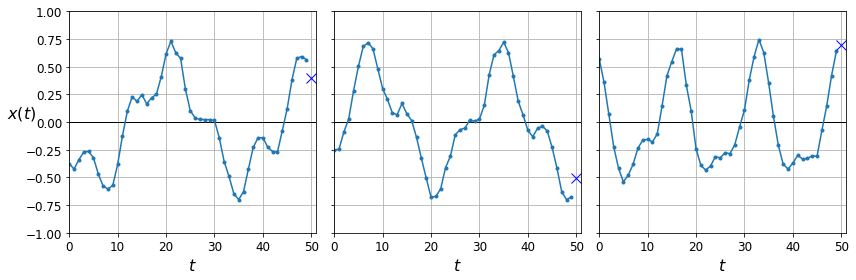

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=('$x(t)$' if col==0 else None))
save_fig("time_series_plot")
plt.show()

## Computing Some Baselines

### Naive Predictions (just predict the last observed value):

In [12]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

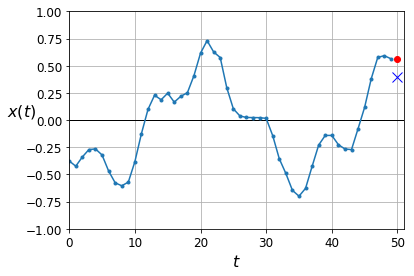

In [13]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Linear Predictions:

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

In [25]:
model.compile(loss='mse',
              optimizer='adam')

In [26]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.1015 - val_loss: 0.0551
Epoch 2/20
7000/7000 [==============================] - 0s 35us/sample - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0205 - val_loss: 0.0161
Epoch 4/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0133 - val_loss: 0.0119
Epoch 5/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0090 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 1

In [27]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 17us/sample - loss: 0.0042


0.00417404793202877

In [28]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5,
             loss, 'b.-', label='Training Loss')
    plt.plot(np.arange(len(val_loss)) + 1,
             val_loss, 'r.-', label='Validation Loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

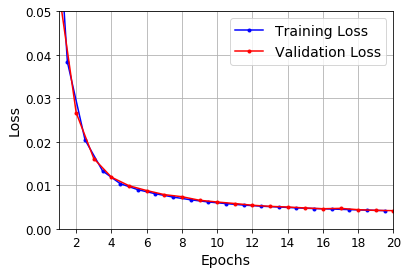

In [29]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

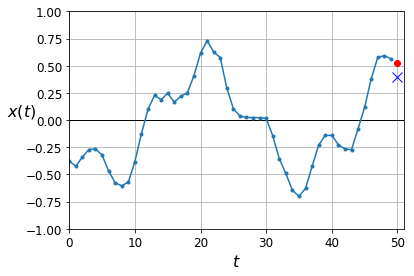

In [30]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [35]:
optimizer = keras.optimizers.Adam(lr=0.005)

In [36]:
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 297us/sample - loss: 0.0960 - accuracy: 0.0000e+00 - val_loss: 0.0482 - val_accuracy: 0.0000e+00
Epoch 2/20
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0366 - accuracy: 0.0000e+00 - val_loss: 0.0293 - val_accuracy: 0.0000e+00
Epoch 3/20
7000/7000 [==============================] - 2s 273us/sample - loss: 0.0251 - accuracy: 0.0000e+00 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 4/20
7000/7000 [==============================] - 2s 268us/sample - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 5/20
7000/7000 [==============================] - 2s 247us/sample - loss: 0.0165 - accuracy: 0.0000e+00 - val_loss: 0.0150 - val_accuracy: 0.0000e+00
Epoch 6/20
7000/7000 [==============================] - 2s 249us/sample - loss: 0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 7/20
7000/

In [38]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 84us/sample - loss: 0.0108 - accuracy: 0.0000e+00


[0.010848855562508107, 0.0]

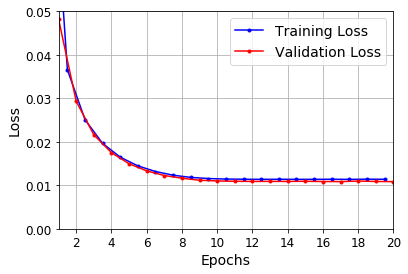

In [39]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

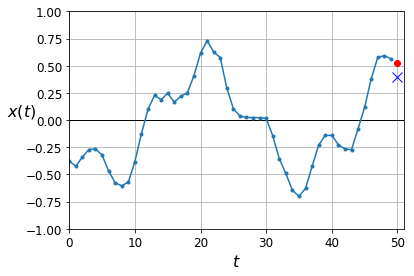

In [40]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNNs:

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [43]:
model.compile(loss='mse', optimizer='adam')

In [44]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0502 - val_loss: 0.0093
Epoch 2/20
7000/7000 [==============================] - 7s 930us/sample - loss: 0.0069 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 6s 920us/sample - loss: 0.0050 - val_loss: 0.0044
Epoch 4/20
7000/7000 [==============================] - 6s 908us/sample - loss: 0.0048 - val_loss: 0.0040
Epoch 5/20
7000/7000 [==============================] - 6s 901us/sample - loss: 0.0041 - val_loss: 0.0037
Epoch 6/20
7000/7000 [==============================] - 6s 894us/sample - loss: 0.0041 - val_loss: 0.0043
Epoch 7/20
7000/7000 [==============================] - 6s 891us/sample - loss: 0.0038 - val_loss: 0.0036
Epoch 8/20
7000/7000 [==============================] - 6s 897us/sample - loss: 0.0037 - val_loss: 0.0032
Epoch 9/20
7000/7000 [==============================] - 6s 894us/sample - loss: 0.0036 - val_loss: 0.0036


In [45]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 242us/sample - loss: 0.0029


0.002889613388106227

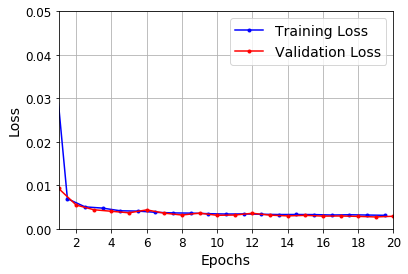

In [46]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

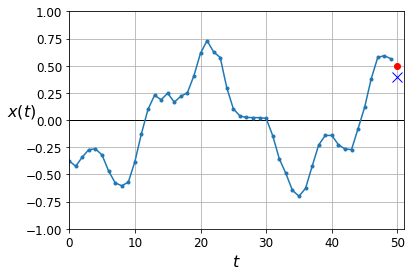

In [47]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Replacing the last layer to a `Dense` layer:

Make the second `SimpleRNN` layer return only the last output:

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [50]:
model.compile(loss='mse',
              optimizer='adam')

In [51]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 833us/sample - loss: 0.0212 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 5s 669us/sample - loss: 0.0041 - val_loss: 0.0034
Epoch 3/20
7000/7000 [==============================] - 5s 665us/sample - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
7000/7000 [==============================] - 5s 643us/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
7000/7000 [==============================] - 5s 646us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 5s 644us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
7000/7000 [==============================] - 5s 664us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 5s 656us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 5s 643us/sample - loss: 0.0030 - val_loss: 0.003

In [52]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 184us/sample - loss: 0.0027


0.0026770312264561653

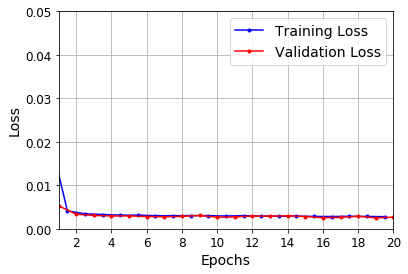

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

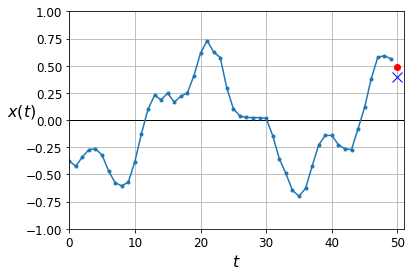

In [55]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [53]:
np.random.seed(43) # not 42, as it would give the first series in the train set

In [56]:
series = generate_time_series(1, n_steps + 10)

X_new, Y_new = series[:, : n_steps], series[:, n_steps :]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead :])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps :]

In [57]:
Y_pred.shape

(1, 10, 1)

In [60]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

Saving figure forecast_ahead_plot


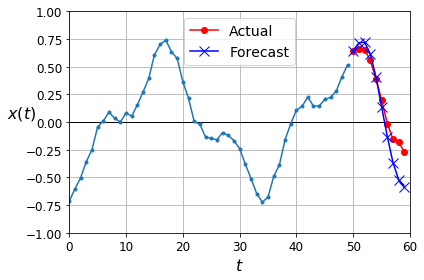

In [61]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [62]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [63]:
X = X_valid

for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [64]:
Y_pred.shape

(2000, 10)

In [65]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.028548893

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [66]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.1334 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 34us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 34us/sample - loss: 0.0385 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0298 - val_loss: 0.0284
Epoch 6/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0256 - val_loss: 0.0248
Epoch 8/20
7000/7000 [==============================] - 0s 34us/sample - loss: 0.0244 - val_loss: 0.0239
Epoch 9/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0234 - val_loss: 0.0229
Epoch 1

Now let's create an RNN that predicts all 10 next values at once:

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [72]:
model.compile(loss='mse',
              optimizer='adam')

In [73]:
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0670 - val_loss: 0.0341
Epoch 2/20
7000/7000 [==============================] - 5s 725us/sample - loss: 0.0267 - val_loss: 0.0195
Epoch 3/20
7000/7000 [==============================] - 5s 749us/sample - loss: 0.0189 - val_loss: 0.0195
Epoch 4/20
7000/7000 [==============================] - 5s 672us/sample - loss: 0.0152 - val_loss: 0.0129
Epoch 5/20
7000/7000 [==============================] - 5s 650us/sample - loss: 0.0136 - val_loss: 0.0125
Epoch 6/20
7000/7000 [==============================] - 5s 655us/sample - loss: 0.0126 - val_loss: 0.0128
Epoch 7/20
7000/7000 [==============================] - 5s 658us/sample - loss: 0.0121 - val_loss: 0.0107
Epoch 8/20
7000/7000 [==============================] - 5s 663us/sample - loss: 0.0112 - val_loss: 0.0109
Epoch 9/20
7000/7000 [==============================] - 5s 669us/sample - loss: 0.0109 - val_loss: 0.010

In [75]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

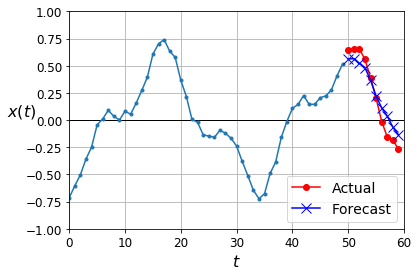

In [76]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [80]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

In [81]:
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [82]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [85]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [86]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 869us/sample - loss: 0.0505 - last_time_step_mse: 0.0395 - val_loss: 0.0422 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 6s 829us/sample - loss: 0.0408 - last_time_step_mse: 0.0306 - val_loss: 0.0421 - val_last_time_step_mse: 0.0350
Epoch 3/20
7000/7000 [==============================] - 5s 723us/sample - loss: 0.0376 - last_time_step_mse: 0.0291 - val_loss: 0.0345 - val_last_time_step_mse: 0.0270
Epoch 4/20
7000/7000 [==============================] - 5s 665us/sample - loss: 0.0317 - last_time_step_mse: 0.0216 - val_loss: 0.0277 - val_last_time_step_mse: 0.0159
Epoch 5/20
7000/7000 [==============================] - 5s 663us/sample - loss: 0.0278 - last_time_step_mse: 0.0162 - val_loss: 0.0269 - val_last_time_step_mse: 0.0149
Epoch 6/20
7000/7000 [==============================] - 5s 662us/sample - loss: 0.0242 - last_time_step_mse: 0.0

In [87]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

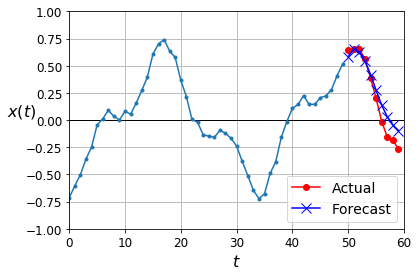

In [88]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Creating a Custom RNN Class

In [90]:
class MyRNN(keras.layers.Layer):
    
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, 'get_initial_state', self.fallback_initial_state)
        
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step, states])
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [91]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", 
              optimizer="adam", 
              metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, 
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

## LSTMs

In [94]:
np.random.seed(42)
tf.random.set_seed(42)

In [95]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True,
                      input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [96]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
model.compile(loss="mse", 
              optimizer="adam", 
              metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, 
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using 1D Convolutional Layer to Process Sequences

    1D conv layer with kernel size 4, stride 2, VALID padding:
    
                  |-----2-----|     |-----5---...------|     |-----23----|
            |-----1-----|     |-----4-----|   ...      |-----22----|
      |-----0----|      |-----3-----|     |---...|-----21----|
  

    X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
    Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
      /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

    Output:

    X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
    Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,
                        kernel_size=4,
                        strides=2,
                        padding='valid',
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [24]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [25]:
model.compile(loss="mse", 
              optimizer="adam", 
              metrics=[last_time_step_mse])

In [ ]:
model.fit(X_train, Y_train[:, 3::2], 
          epochs=20,
          validation_data=(X_valid, Y_valid[:, 3::2]))

## WaveNet

    C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
       \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
         /    \      /    \      /    \                 /    \
    C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
    X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
    Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
      /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss="mse", 
              optimizer="adam", 
              metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, 
                    epochs=20,
                    validation_data=(X_valid, Y_valid))